# Word2Vec 학습하기
 - gensim을 이용한 한국어 word2vec 학습실습
 - 딥 러닝을 이용한 자연어 처리 입문의 코드를 기반으로 가공함

In [1]:
import gensim
gensim.__version__

'4.3.1'

## 01. Install required packages 

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 24.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

## 02. Preprocessing of the datasets

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f2cc377f730>)

In [5]:
train_data = pd.read_table('ratings.txt')

In [6]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [7]:
print('리뷰 개수 :',len(train_data))
print('NULL 값 존재 유무 :', train_data.isnull().values.any())

리뷰 개수 : 200000
NULL 값 존재 유무 : True


In [8]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('NULL 값 존재 유무 :', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

NULL 값 존재 유무 : False


In [9]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-9-d10eedfa8951>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [10]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [11]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [14]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [15:09<00:00, 219.92it/s]


In [28]:
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다'], ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고']]


## 03. EDA and visualize

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


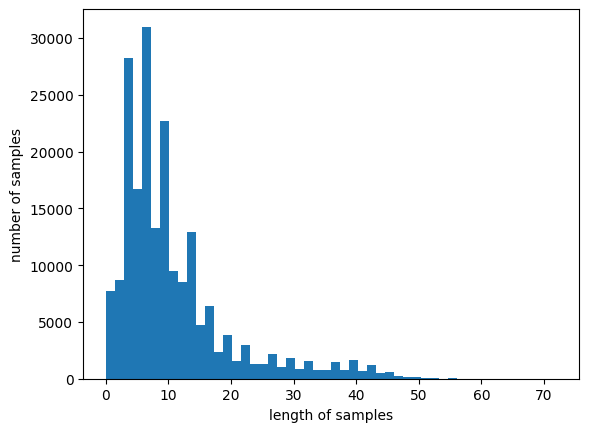

In [29]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 04. Training

In [17]:
from gensim.models import Word2Vec

In [30]:
model = Word2Vec(sentences = tokenized_data, vector_size = 50, window = 2, min_count = 5, workers = 4, sg = 1)

In [31]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (16477, 50)


In [32]:
print(model.wv.most_similar("최민식"))

[('김명민', 0.9078643918037415), ('한석규', 0.8757477402687073), ('조재현', 0.8723832368850708), ('서영희', 0.8721603155136108), ('유오성', 0.8712039589881897), ('송강호', 0.8685230612754822), ('이정재', 0.8644595146179199), ('김승우', 0.8641092777252197), ('이민호', 0.8640965819358826), ('디카프리오', 0.8634458780288696)]


In [33]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8711501955986023), ('갱스터', 0.8447554111480713), ('첩보', 0.8414634466171265), ('무협', 0.8389765024185181), ('좀비', 0.8368465900421143), ('로멘틱', 0.8346772193908691), ('로맨스코미디', 0.8333368301391602), ('정통', 0.8331096172332764), ('느와르', 0.8304091095924377), ('괴수', 0.8299553990364075)]


In [34]:
model.wv["최민식"]

array([-0.13331057,  0.06312925,  0.10793948, -0.22967693, -0.5255159 ,
       -0.23522449,  0.23052704,  0.8708131 , -0.35583675, -0.5679744 ,
        0.16254576, -0.00351416, -0.2693059 ,  0.32634985,  0.34977478,
       -0.22567235,  0.35078937,  0.05857151, -0.4359703 , -0.28894687,
       -0.07014415, -0.05458168,  0.36217657, -0.02112469,  0.26385742,
       -0.12338662, -0.27238607, -0.05231785, -0.45333564,  0.37818313,
       -0.3167387 , -0.21273366, -0.20942043,  0.07668708, -0.06112419,
       -0.21729837,  0.6240683 ,  0.03996474, -0.05011546, -0.15578644,
        0.51258093, -0.15296733,  0.24894501,  0.12791581,  0.33296302,
       -0.24082612,  0.08221554, -0.4448635 ,  0.23259126,  0.03187333],
      dtype=float32)

In [35]:
model.wv["김명민"]

array([-0.13941059,  0.0433824 , -0.07692135, -0.3377992 , -0.47148398,
       -0.17765135,  0.08751349,  0.8260031 , -0.1278858 , -0.4919802 ,
        0.20398867, -0.00949744, -0.03217837,  0.2778785 ,  0.29099488,
       -0.14678426,  0.47507864,  0.19698687, -0.42873788, -0.29705706,
       -0.0181989 ,  0.09058763,  0.19954112, -0.17562787,  0.21085173,
       -0.05739055, -0.36162263, -0.04364209, -0.3856552 ,  0.3905589 ,
       -0.22897013, -0.10810561, -0.15680495,  0.08968076, -0.11364145,
        0.06723965,  0.66389275,  0.05452222, -0.30107376, -0.21822172,
        0.83763945,  0.01212191,  0.2561838 , -0.20097551,  0.48202637,
       -0.41656968,  0.06158689, -0.39737016,  0.02240455, -0.0813309 ],
      dtype=float32)

In [27]:
model.wv.save_word2vec_format("word2vec_ko_50.model")

## 05. Loading from External word embeddings
 - 구글에서 미리 학습해둔 영어 word embedding을 다운로드받아 바로 활용해보자!

In [ ]:
import gensim
import urllib.request

In [ ]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
print(word2vec_model.vectors.shape)

In [ ]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

In [ ]:
print(word2vec_model['book'])